<a href="https://colab.research.google.com/github/NipuniSdSR/NODE/blob/main/02_NODE_Vanderpol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# System: Van der Pol oscillator
$\frac{d^2x}{dt^2} - μ (1- x^2)\frac{dx}{dt} + x = 0$

Sytem in two dimensional form:

$ \dot{x} = y \\
  \dot{y} =  μ (1- x^2)y - x 
$


In [ ]:
# Import the packages

%pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

from torchdiffeq import odeint

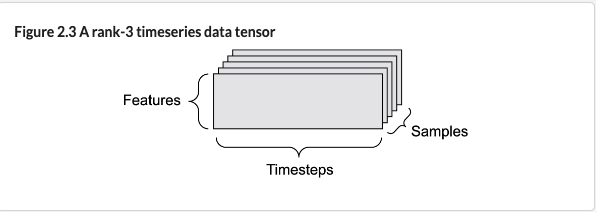

In [ ]:
class VanDerPol(nn.Module):
  def __init__(self, mu):
    super().__init__()
    self.mu = mu


  def forward(self, t, y):
    dy = torch.zeros_like(y)
    dy[0] = y[1]
    dy[1] = self.mu*(1 - y[0]**2)*y[1] - y[0]

    return dy


In [ ]:
noDim = 2
noICs = 10
dt = 0.5
t0 = 0.
tEnd = 100.
mu = 1.0

In [ ]:
vanDerPol = VanDerPol(mu)

In [ ]:
print(vanDerPol.forward(0,torch.tensor([2,1])).shape)

torch.Size([2])


In [ ]:


vanDerPol = VanDerPol(mu)
ics = torch.tensor(np.random.rand(noDim, noICs) * 3.0)
t = torch.arange(t0, tEnd, dt)

data_size = len(t)

In [ ]:
ics = ics.type(torch.float32)

In [ ]:
def createTrainingData(ics, rhs, t):

  """
  inputs:
  ics : array of initial conditions
  rhs : Right Hand Side of the system ODE
  t   : time steps

  Output:
  trueY : state values of the system as a 3D tensor
    height (0 dim)         : samples/IC
    lenght/columns (1 dim) : time steps
    width/rows (2 dim)     : features/dimension
  """


  trueY = torch.empty((ics.shape[1], len(t), ics.shape[0]), dtype=ics.dtype, device=ics.device)

  for i in range(ics.shape[1]):
    s = odeint(func = rhs, 
               y0=ics[:,i],
               t=t, 
               rtol=1e-3, atol=1e-5, method='dopri5') # integrator parameters
    trueY[i,:,:]=s#torch.permute(s,(1,0))
  return trueY

In [ ]:

trueY = createTrainingData(ics, vanDerPol, t)
trueY.shape

torch.Size([10, 200, 2])

In [ ]:
def visualize(trueY, pred_y=None, itr = 00):
  fig = plt.figure(figsize=(6, 6), facecolor='white')
  ax = fig.add_subplot(111)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  for s in range(trueY.shape[0]):
    ax.plot(trueY.numpy()[s,:, 0], trueY.numpy()[s, :, 1],'cyan' ,label='true trajectory'+str(s+1))
  if pred_y is not None:
    ax.plot(pred_y.numpy()[:,0], pred_y.numpy()[:,1], 'red', label='learned trajectory')

  plt.legend()
  plt.grid(True)
  plt.show()



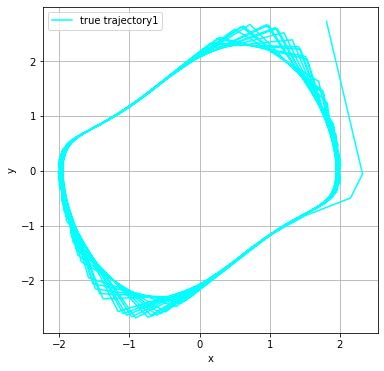

In [ ]:
visualize(trueY[np.random.randint(noICs),None,:,:])

## Create Neural ODE model
Define dynamic function to create the trajectory using NODE

In [ ]:
class CreateNODEFunction(nn.Module):
  """
  layersDepth : an array of size 2
  layersDepth = [dimension of the system, Hidden layer dimension]
  """
  def __init__(self, layersDepth) -> None:
    super().__init__()
    self.net =  nn.Sequential(nn.Linear(layersDepth[0],layersDepth[1]),
                              nn.Tanh(),
                              # nn.Linear(layersDepth[1],layersDepth[2]),
                              # nn.ReLU(),
                              nn.Linear(layersDepth[1],layersDepth[0]))

    for m in self.net.modules():
      if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0, std=0.1)
        nn.init.constant_(m.bias, val=0)

  def forward(self, t, y):
    output = self.net(y)
    return output

# Training the NODE model

This function has two adaptive solvers to train the model

1. odeint
2. odeint_adjoint

function is using odeint by default.

In [ ]:
# Selecting batches to train the model

# setting up batches in same trajectory but with various starting points
# consecative batch_size points with different starting point


batch_time = 10
batch_size = 24


def get_batch():
  # selecting roandom trajectory
  ic = np.random.randint(noICs)
  trajec = trueY[ic]
  # random starting points equl to batch_size
  s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype = np.int64), batch_size, replace=False))

  batch_y0 = trajec[s] #(batch_size, dim)

  batch_t = t[:batch_time] #(T)
  batch_y = torch.stack([trajec[s+i] for i in range(batch_time)], dim=0) #(time, batch_size, dim)

  return batch_y0, batch_t, batch_y, ic

In [ ]:
batch_y0, batch_t, batch_y,trajec = get_batch()
print(batch_y0.shape, batch_t.shape, batch_y.shape,trajec)

torch.Size([24, 2]) torch.Size([10]) torch.Size([10, 24, 2]) 5


In [ ]:
batch_y.dtype

torch.float32

In [ ]:
func = CreateNODEFunction([2,64])

  0%|          | 0/5001 [00:00<?, ?it/s]

Iter 0000| Total Loss 1.540112


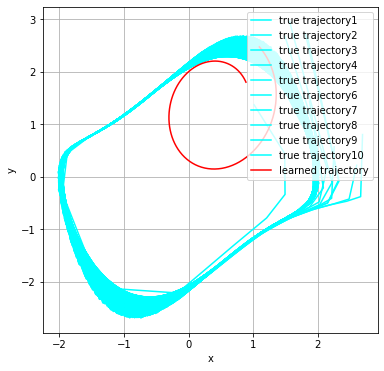

Iter 0200| Total Loss 0.473768


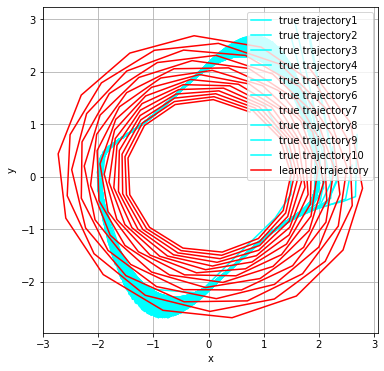

Iter 0400| Total Loss 1.090214


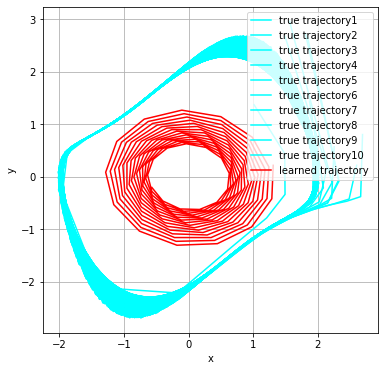

Iter 0600| Total Loss 1.092555


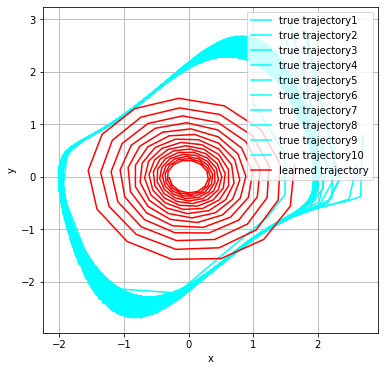

Iter 0800| Total Loss 1.223877


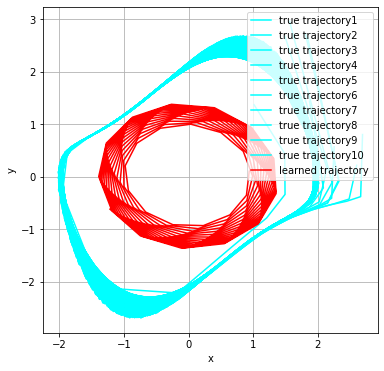

Iter 1000| Total Loss 0.701683


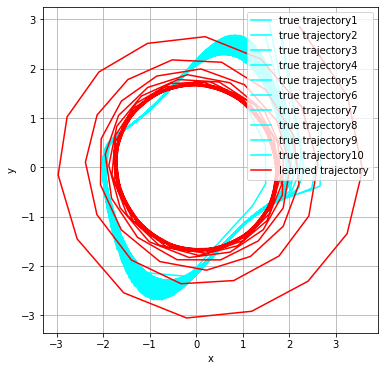

Iter 1200| Total Loss 0.925913


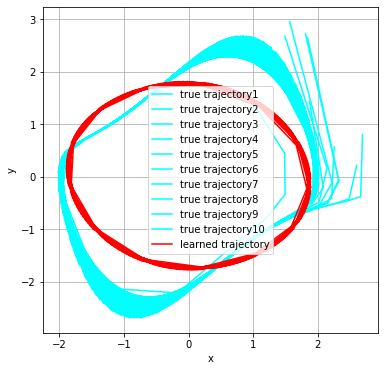

Iter 1400| Total Loss 0.751268


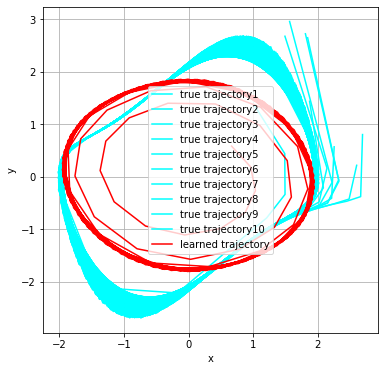

Iter 1600| Total Loss 0.597587


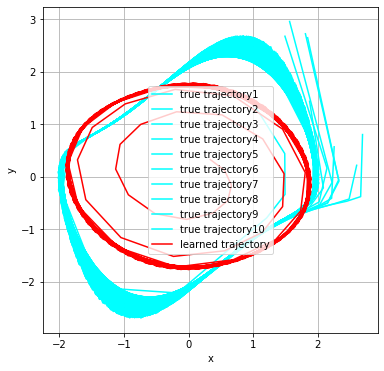

Iter 1800| Total Loss 0.674944


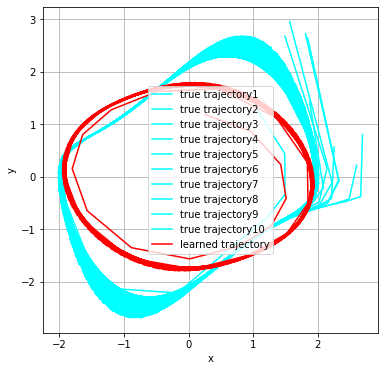

Iter 2000| Total Loss 1.358142


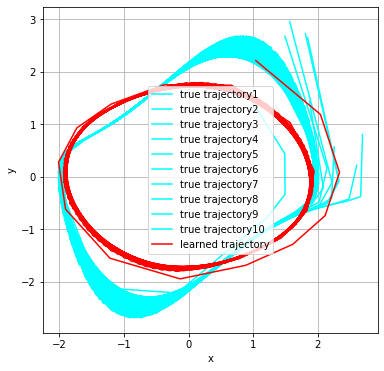

Iter 2200| Total Loss 1.573571


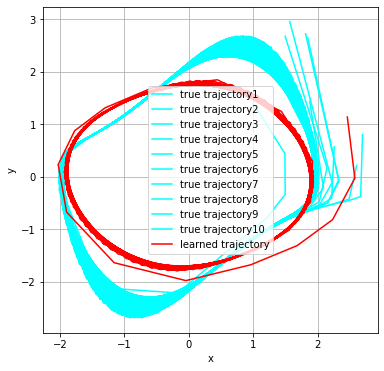

Iter 2400| Total Loss 0.366658


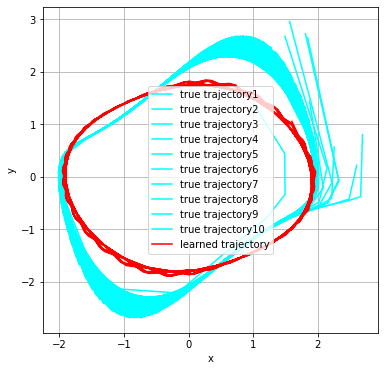

Iter 2600| Total Loss 0.963777


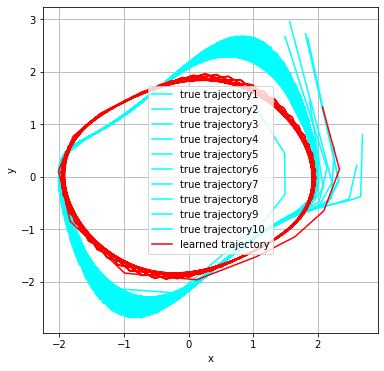

Iter 2800| Total Loss 0.977198


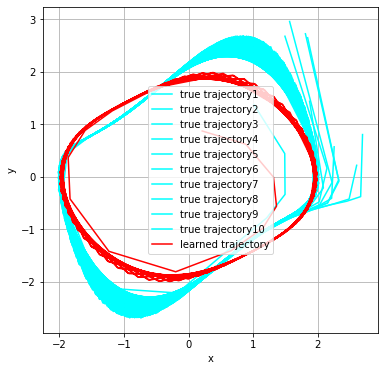

Iter 3000| Total Loss 1.780818


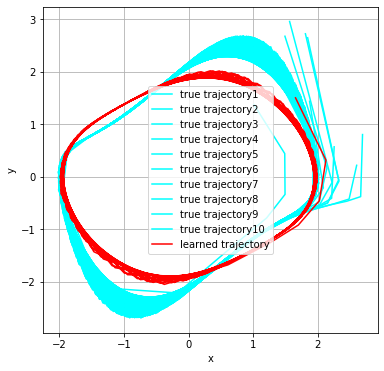

Iter 3200| Total Loss 0.637458


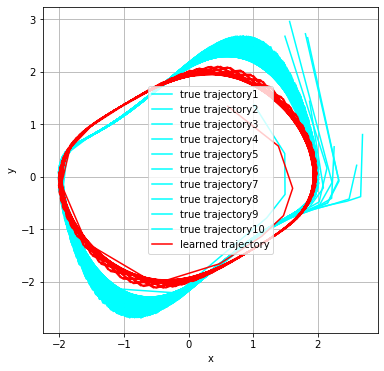

Iter 3400| Total Loss 1.722993


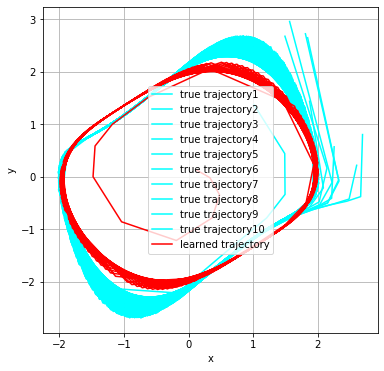

Iter 3600| Total Loss 1.206327


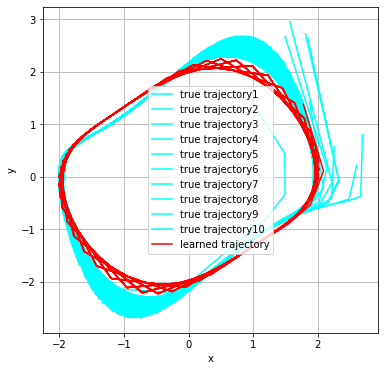

Iter 3800| Total Loss 0.563245


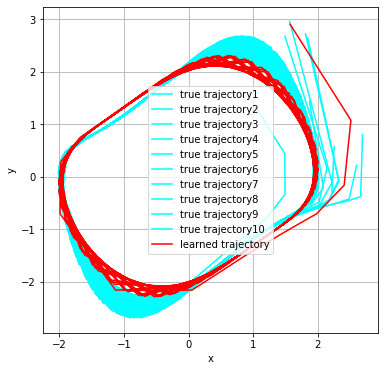

Iter 4000| Total Loss 0.641580


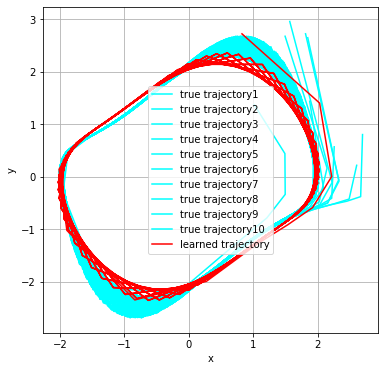

Iter 4200| Total Loss 1.491287


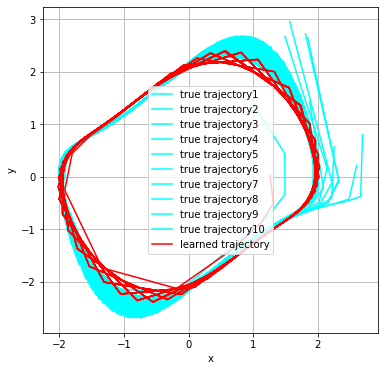

Iter 4400| Total Loss 0.288114


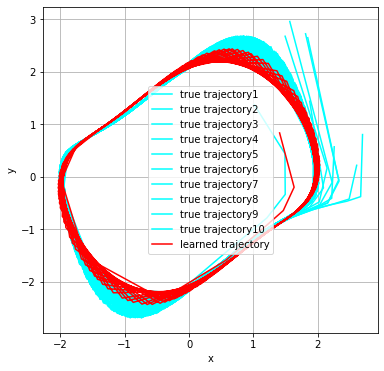

Iter 4600| Total Loss 2.116589


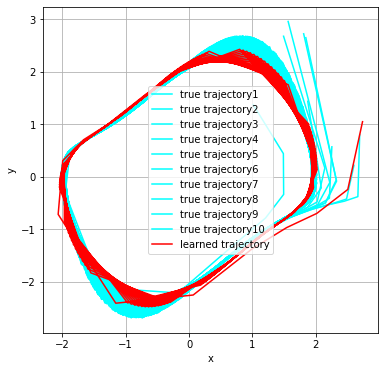

Iter 4800| Total Loss 1.652842


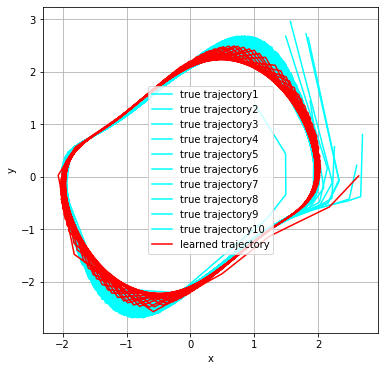

Iter 5000| Total Loss 0.394913


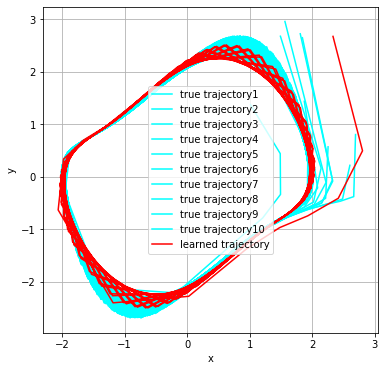

Process time: 705.980642080307sec


In [ ]:
solver_adjoint = False
niters = 5000

if solver_adjoint:
  from torchdiffeq import odeint_adjoint as odeint


optimizer =  optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):

  optimizer.zero_grad()

  batch_y0, batch_t, batch_y,trajec = get_batch()

  pred_y = odeint(func=func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
  loss = torch.mean(torch.abs(pred_y - batch_y))

  loss.backward()
  optimizer.step()


  #testing
  if iter % 200 == 0:
    with torch.no_grad():
      y0 = torch.tensor(np.random.rand(2)*3.0).type(torch.float32)
      pred_y = odeint(func, y0 = y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')
      trueYOfPred = odeint(vanDerPol, y0 = y0, t=t, rtol=1e-7, atol=1e-9, method='dopri5')

      loss = torch.mean(torch.abs(pred_y -trueYOfPred))
      print("Iter {:04d}| Total Loss {:6f}".format(iter, loss.item()))

      visualize(trueY, pred_y)

end_time = time.time() - start_time

print("Process time: {}sec".format(end_time))